In [1]:
import os
import sys
import argparse
import logging
import datetime
import json
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from textwrap import wrap

from transformers import TrainingArguments, Trainer

import torch
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from dataset_config import COCO_dataset_config
from utils import get_device_map

%matplotlib inline

os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
devices = [1, 5, 6, 7]
start_device = 'cuda:' + str(devices[0])

### Logging

In [3]:
# train result save dir name
results_dir = '../results'
result_dirname = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
result_dir_fullpath = os.path.join(results_dir, result_dirname)
os.makedirs(result_dir_fullpath, exist_ok=True)

In [4]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s: %(message)s",
    level=logging.INFO,
    datefmt="%I:%M:%S",
    handlers=[
        logging.FileHandler(os.path.join(result_dir_fullpath, 'train.log')),
        logging.StreamHandler(sys.stdout),
    ])

In [5]:
# tensorboard
writer = SummaryWriter(os.path.join('../runs', result_dirname))

### Configuration

In [6]:
# blip2 설정 참고하기
# https://github.com/salesforce/LAVIS/blob/main/lavis/projects/blip2/train/caption_coco_ft.yaml

# checkpoint = "Salesforce/blip2-opt-2.7b"
checkpoint = "Salesforce/blip2-flan-t5-xl"
# cache_dir = "/mnt/nas2/kjh/huggingface_cache"
cache_dir = "../pretrained_files"
cfg_path = "../configs/caption_coco_ft.yaml"
dtype = torch.float32
batch_size = 4
num_workers = 4
max_length = 50
epochs = 5
learning_rate = 1e-4
prompt = "a photo of "

model_name = checkpoint.split("/")[1]

In [7]:
from omegaconf import OmegaConf, DictConfig

config = OmegaConf.load(cfg_path)

print(config)

def dict_to_str_recursive(input_dict, depth=0):
    result_str = ''
    indent_str = '&nbsp;&nbsp;&nbsp;&nbsp;' * depth
    for key in input_dict:
        if type(input_dict[key]) in [dict, DictConfig]:
            value_str = dict_to_str_recursive(input_dict[key], depth + 1)
            result_str += indent_str + str(key) + ':  \n' + value_str + '  \n'
        else:
            value_str = str(input_dict[key])
            result_str += indent_str + str(key) + ': ' + value_str + '  \n'
    return result_str

config_str = dict_to_str_recursive(config)
writer.add_text('configs', config_str)

{'run': {'task': 'captioning', 'lr_sched': 'linear_warmup_cosine_lr', 'init_lr': 1e-06, 'min_lr': 0, 'warmup_lr': 1e-08, 'warmup_steps': 1000, 'weight_decay': 0.05, 'max_epoch': 5, 'batch_size_train': 16, 'batch_size_eval': 8, 'num_workers': 4, 'accum_grad_iters': 1, 'max_len': 30, 'min_len': 8, 'num_beams': 5, 'seed': 42, 'output_dir': 'output/BLIP2/Caption_coco', 'amp': True, 'resume_ckpt_path': None, 'evaluate': False, 'train_splits': ['train'], 'valid_splits': ['val'], 'test_splits': ['test'], 'world_size': 1}}


### Processor
##### image-processor + tokenizer

In [8]:
from transformers import Blip2Processor

processor = Blip2Processor.from_pretrained(
    checkpoint,
    cache_dir=cache_dir,
    torch_dtype=dtype
)

### Dataset

In [9]:
from datasets import load_dataset
train_ds = load_dataset('../datasets/cvpr-nice-val/', split='validation')
caption_ds = load_dataset('../datasets/cvpr-nice-val', data_files={'caption': 'nice-val-5k.csv'}, split='caption')
for feature in caption_ds.features:
    print(feature)
    train_ds = train_ds.add_column(name=feature, column=caption_ds[feature])
    
# column명 변경
train_ds.rename_column("image", "images")

Resolving data files: 100%|██████████| 5001/5001 [00:00<00:00, 5684.82it/s] 


05:18:53 - WARNING: Found cached dataset imagefolder (/home/kjh/.cache/huggingface/datasets/imagefolder/cvpr-nice-val-d952af713765ee6a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
05:18:53 - WARNING: Found cached dataset csv (/home/kjh/.cache/huggingface/datasets/csv/cvpr-nice-val-f8121514c023db56/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
public_id
caption_gt
category


Dataset({
    features: ['images', 'public_id', 'caption_gt', 'category'],
    num_rows: 5000
})

In [10]:
print(train_ds)

Dataset({
    features: ['image', 'public_id', 'caption_gt', 'category'],
    num_rows: 5000
})


In [11]:
prompt_tokens = processor.tokenizer(
    prompt, padding='max_length', max_length=max_length
)

In [12]:
def transforms(input_batch, prefix=None):
    if prefix is not None:
        input_batch['caption_gt'] = prefix + input_batch['caption_gt']
    # batch = processor(images=batch['image'], text=batch['caption_gt'], padding="max_length", max_length=max_length, return_tensors='pt')
    batch = processor(images=input_batch['image'], text=prompt, padding="max_length", max_length=max_length, return_tensors='pt')
    batch['pixel_values'] = batch['pixel_values'].squeeze(0)
    batch.update({'labels': processor.tokenizer(input_batch['caption_gt'], padding='max_length', max_length=max_length)['input_ids']})
    batch.update({'input_ids': batch['input_ids'].squeeze(0)})
    del batch['attention_mask']     # 이거 해야하나 말아야하나.. forward에서 'attention_mask' 지정 안해주면 알아서 만들어 주는 거 같은데
    # batch.update({'decoder_input_ids': prompt_tokens['input_ids']})
    return batch

In [13]:
train_ds = train_ds.map(
    transforms,
    remove_columns=['public_id', 'caption_gt', 'image', 'category'],
)
# batch 설정하면 왜인지 pixel_values가 이상해짐 & 변환할 때 image가 있어서 그런지 더 느려짐


05:18:54 - WARNING: Loading cached processed dataset at /home/kjh/.cache/huggingface/datasets/imagefolder/cvpr-nice-val-d952af713765ee6a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-a09858a61ddbedcc.arrow


In [14]:
print(train_ds)

Dataset({
    features: ['pixel_values', 'input_ids', 'labels'],
    num_rows: 5000
})


### Plot Images

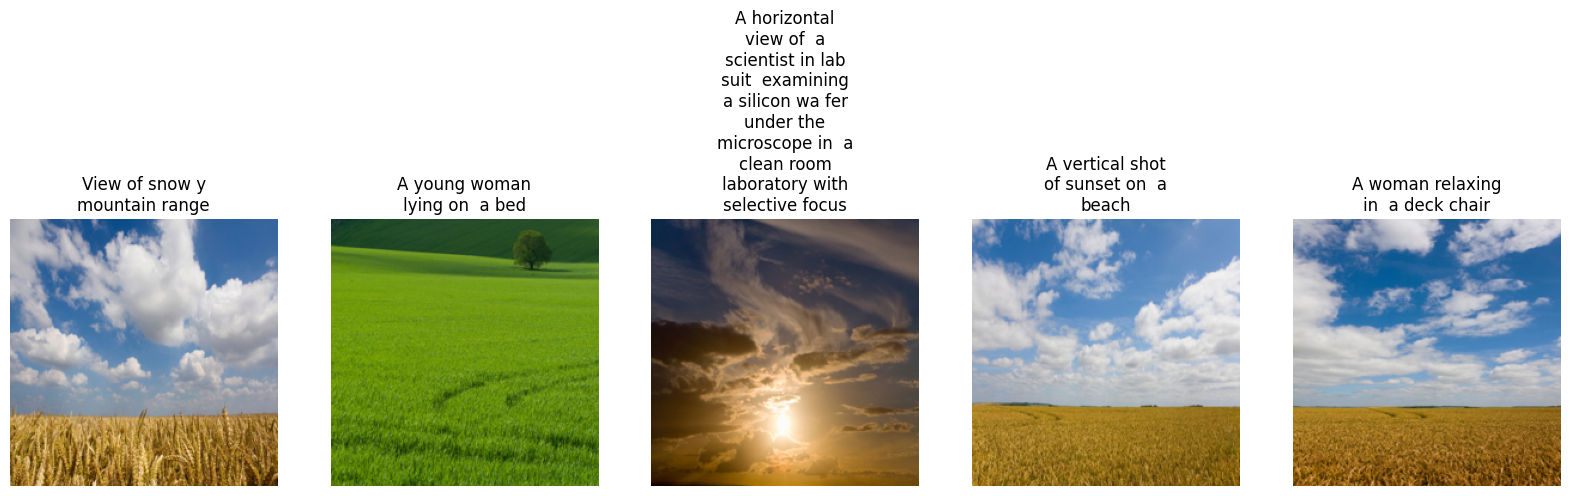

In [15]:
def denormalize_image(normalized_image, mean, std):
    image = normalized_image.transpose(1, 2, 0)
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    return image

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 16))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

num_samples = 5
samples = [train_ds[i] for i in range(num_samples)]

sample_images = []
sample_captions = []
for i in range(num_samples):
    sample_image = np.array(samples[i]['pixel_values'])
    sample_image = denormalize_image(sample_image, processor.image_processor.image_mean, processor.image_processor.image_std)
    sample_images.append(sample_image)
    
    sample_caption = ' '.join(processor.batch_decode(samples[i]['labels'], skip_special_tokens=True))
    sample_captions.append(sample_caption)

plot_images(sample_images, sample_captions)

### Model

In [16]:
from transformers import Blip2ForConditionalGeneration

device_map = get_device_map(checkpoint, devices)

model = Blip2ForConditionalGeneration.from_pretrained(
    checkpoint,
    cache_dir=cache_dir,
    torch_dtype=dtype,
    device_map=device_map,
    low_cpu_mem_usage=True,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:23<00:00, 11.50s/it]


In [17]:
# Freeze
block_list = [
    model.vision_model,
    model.qformer,
    model.language_projection,
    model.language_model,
]

freeze_list = [
    # model.vision_model,
    # model.qformer,
    # model.language_projection,
    model.language_model,
]

for freeze_block in freeze_list:
    for name, param in freeze_block.named_parameters():
        param.requires_grad = False
    freeze_block = freeze_block.eval()

for block in block_list:
    if block not in freeze_list:
        for name, param in block.named_parameters():
            param.requires_grad = True
    block = block.train()

### Train

In [18]:
training_args = TrainingArguments(
    output_dir=f"../training_outputs/{model_name}",
    learning_rate=learning_rate,
    num_train_epochs=epochs,
    fp16=True if dtype is torch.float16 else False,
    fp16_opt_level="02",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1,
    save_total_limit=3,
    save_strategy="epoch",
    logging_steps=100,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=['labels'],
)
training_args.set_lr_scheduler(name='linear', warmup_steps=1000)
training_args.set_optimizer(name='adamw_hf', learning_rate=1e-6, weight_decay=0.05)

TrainingArguments(
_n_gpu=8,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=02,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignor

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=None,
)

In [20]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [21]:
from torch.cuda.amp import autocast

with autocast(dtype=dtype):
    result = trainer.train()
    print_summary(result)

/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,35.860600
200,35.452700


Time: 4670.41
Samples/second: 3.21
GPU memory occupied: 6407 MB.


--- Logging error ---
Traceback (most recent call last):
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/site

hochwertige Erkenntnisse instanţ haine Polica vreau


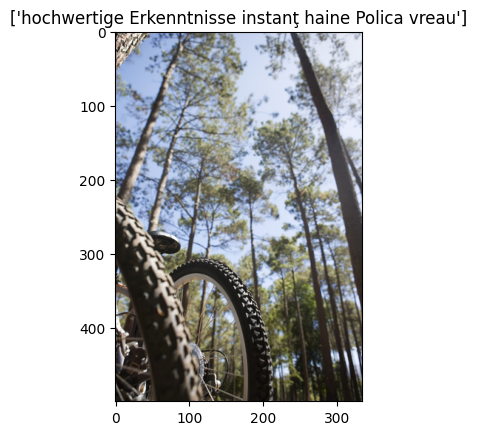

In [28]:
from PIL import Image
from utils import show_image_caption

image = '../datasets/cvpr-nice-val/val/215268662.jpg'
raw_image = Image.open(image).convert('RGB')

inputs = processor(raw_image, return_tensors="pt").to(start_device, dtype)

generated_ids = model.generate(**inputs, max_new_tokens=max_length)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

show_image_caption(raw_image, [generated_text], show_fig=True)

### Training